In [1]:
import pandas as pd
from scipy.spatial import distance_matrix

df = pd.DataFrame(dict(x=[0, 0, 1, 4, 5, 6], y=[1, 0, 0, 4, 4, 6]))
display(df)
d_matrix = pd.DataFrame(distance_matrix(df, df))
d_matrix

,x,y
0,0,1
1,0,0
2,1,0
3,4,4
4,5,4
5,6,6


,0,1,2,3,4,5
0,0.000000,1.000000,1.414214,5.000000,5.830952,7.810250
1,1.000000,0.000000,1.000000,5.656854,6.403124,8.485281
2,1.414214,1.000000,0.000000,5.000000,5.656854,7.810250
3,5.000000,5.656854,5.000000,0.000000,1.000000,2.828427
4,5.830952,6.403124,5.656854,1.000000,0.000000,2.236068
5,7.810250,8.485281,7.810250,2.828427,2.236068,0.000000


## K-Means

In [2]:
centroides = pd.DataFrame(dict(x=[1, 5], y=[1, 6]))
centroides_2 = pd.DataFrame(dict(x=[1 / 3, 5], y=[1 / 3, 14 / 3]))

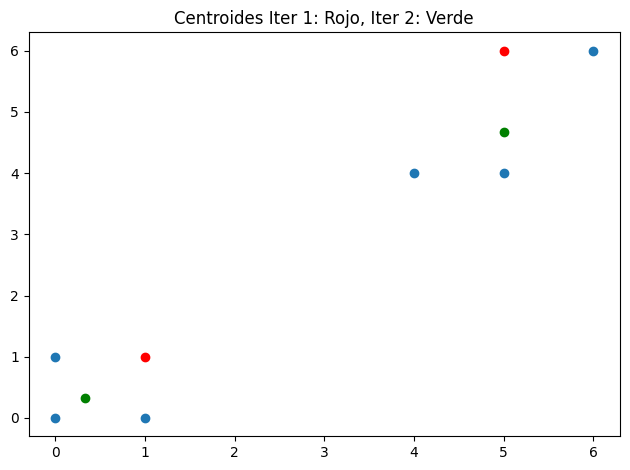

In [3]:
import matplotlib.pyplot as plt

plt.scatter(df.x, df.y)
plt.scatter(centroides.x, centroides.y, c="red")
plt.scatter(centroides_2.x, centroides_2.y, c="green")
plt.title("Centroides Iter 1: Rojo, Iter 2: Verde")
plt.tight_layout()

In [4]:
## Distancia Centroides 1 a Puntos
pd.DataFrame(distance_matrix(centroides, df))

,0,1,2,3,4,5
0,1.000000,1.414214,1.000000,4.242641,5.0,7.071068
1,7.071068,7.810250,7.211103,2.236068,2.0,1.000000


In [5]:
## Distancia Centroides 2 a Puntos
pd.DataFrame(distance_matrix(centroides_2, df))

,0,1,2,3,4,5
0,0.745356,0.471405,0.745356,5.18545,5.934831,8.013877
1,6.200358,6.839428,6.146363,1.20185,0.666667,1.666667


## DBSCAN

In [6]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(min_samples=2, eps=2)
dbs.fit_predict(df)

array([ 0,  0,  0,  1,  1, -1])

In [7]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(min_samples=1, eps=1)
dbs.fit_predict(df)

array([0, 0, 0, 1, 1, 2])

## Jerarquico Linkage Complete

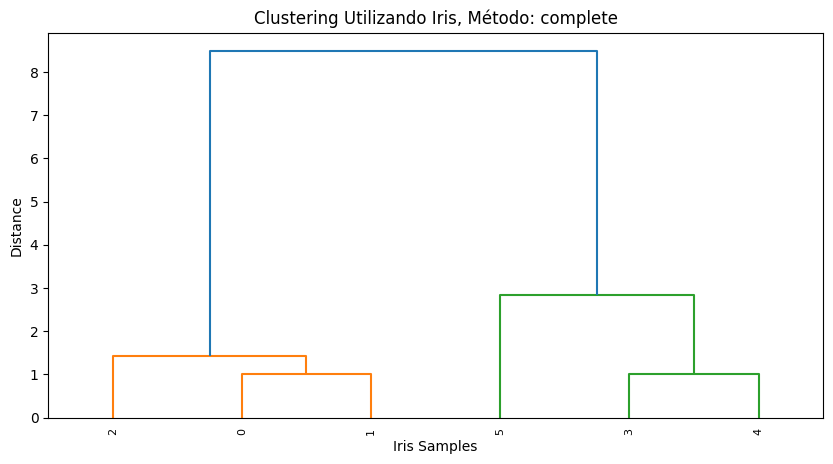

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage


def plot_dendogram(X, link="ward"):
    Z = linkage(X, method=link)

    plt.figure(figsize=(10, 5))
    plt.title(f"Clustering Utilizando Iris, Método: {link}")
    plt.xlabel("Iris Samples")
    plt.ylabel("Distance")
    dendrogram(Z, leaf_rotation=90.0, leaf_font_size=8.0)
    plt.show()


plot_dendogram(df, link="complete")

## Cohesión y Separación

In [9]:
import numpy as np


def compute_clustering_metrics(X, labels, centers, is_df=True):
    if is_df:
        X = X.to_numpy()
    sse = np.square(X - centers[labels]).sum()
    count = np.bincount(labels)
    ssb = (
        np.square(X.mean(axis=0) - centers) * count.reshape(-1, 1)
    ).sum()
    return sse, ssb


labels = np.array([0, 0, 0, 1, 1, 1])
centers = centroides_2.values
sse, ssb = compute_clustering_metrics(df, labels, centers, is_df=True)
sse, ssb

(6.0, 60.833333333333336)

## Silhouette

In [10]:
def silhouette_score_m(d_matrix, clust_labels):
    n_clusters = len(np.unique(clust_labels))
    clusters = clust_labels
    idx_cohesion = clusters == np.arange(n_clusters).reshape(-1, 1)
    a = np.zeros_like(clusters, dtype=np.float32)
    bj = np.zeros((len(clusters), n_clusters))
    for i, (row, c) in enumerate(zip(d_matrix, clusters)):
        val = row[idx_cohesion[c] & (row != 0)]
        a[i] = val.mean() if len(val) else 0
        for cl in range(n_clusters):
            if cl != c:
                val = row[idx_cohesion[cl]]
                bj[i, cl] = val.mean() if len(val) else 0

    b = np.sort(bj, axis=1)[:, 1]
    return a, b, bj, n_clusters


d_matrix = distance_matrix(df, df)
a, b, bj, n_clusters = silhouette_score_m(d_matrix, labels)


def create_table_for_silhouette(a, b, bj, n_clusters):
    s_score = (b - a) / np.max((a, b), axis=0)
    columns = (
        ["a"] + ["b" + str(i) for i in range(n_clusters)] + ["b", "s"]
    )

    s_table = pd.DataFrame(
        np.hstack(
            [
                a.reshape(-1, 1),
                bj,
                b.reshape(-1, 1),
                s_score.reshape(-1, 1),
            ]
        ),
        columns=columns,
    )
    return s_table


s_score_table = create_table_for_silhouette(a, b, bj, n_clusters)
s_score_table["s"].mean()

0.7517302154855591

In [11]:
s_score_table

,a,b0,b1,b,s
0,1.207107,0.000000,6.213734,6.213734,0.805736
1,1.000000,0.000000,6.848420,6.848420,0.853981
2,1.207107,0.000000,6.155701,6.155701,0.803904
3,1.914214,5.218951,0.000000,5.218951,0.633219
4,1.618034,5.963643,0.000000,5.963643,0.728684
5,2.532248,8.035260,0.000000,8.035260,0.684858
